In [1]:
%matplotlib inline

from pathlib import Path
from drone_detector.tiling import *
import os, sys
import geopandas as gpd

# Make data

In [2]:
tile_folder = Path('../data/hiidenportti/raw/plot_patches/')
vector_folder = Path('../data/hiidenportti/raw/vector_plots/')

outpath = Path('../data/hiidenportti/processed_unet/')

if not os.path.exists(outpath): os.makedirs(outpath)

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('shp')]
assert len(tiles) == len(vectors)

In [3]:
import rasterio as rio

In [ ]:
for t in tiles:
    with rio.open(tile_folder/t) as f:
        im = f.read()
        tilesize = min(im.shape[1], im.shape[2])/8
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = f'{t.split("_")[0]}.shp'
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname)
    for patch in (f'{tiler.vector_path}/{f}' for f in os.listdir(tiler.vector_path) if f.endswith('geojson')):
        gdf = gpd.read_file(patch)
        gdf['geometry'] = gdf.geometry.buffer(0.05)
        gdf.to_file(patch, driver='GeoJSON')
    tiler.tile_and_rasterize_vector('groundwood')

# Train model

In [4]:
from fastai.vision.all import *
from drone_detector.visualizations import *
from drone_detector.data import *

def label_func(fn): 
    return str(fn).replace('raster_tiles', 'rasterized_vector_tiles')

In [5]:
fnames = [Path(f'{outpath}/{tile}/raster_tiles/{f}') 
          for tile in [til for til in os.listdir(outpath) if os.path.isdir(outpath/til)]
          for f in os.listdir(outpath/tile/'rasterized_vector_tiles/')]

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   codes=['Standing', 'Fallen'],
                                                   fnames=fnames,
                                                   label_func=label_func,
                                                   item_tfms=[Resize(256)],
                                                   batch_tfms= [
                                                       *aug_transforms(size=224),
                                                       Normalize.from_stats(*imagenet_stats)
                                                   ])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggere

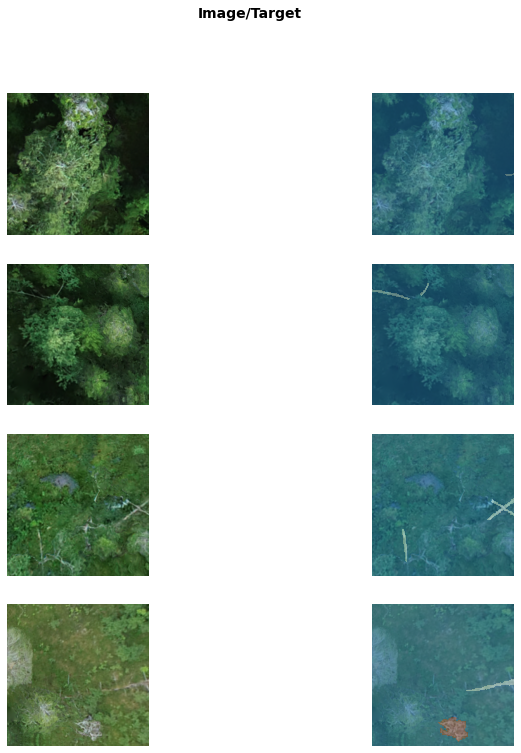

In [7]:
deadwood.show_batch(max_n=8)

In [6]:
from drone_detector.losses import LovaszSoftmaxLossFlat, FocalDice
from drone_detector.metrics import JaccardCoeffMulti

learn = unet_learner(deadwood, resnet101, pretrained=True, n_in=3, n_out=3,
                     metrics=[DiceMulti(), JaccardCoeffMulti()], loss_func=LovaszSoftmaxLossFlat()
                    ).to_fp16()

SuggestedLRs(valley=0.00010964782268274575)

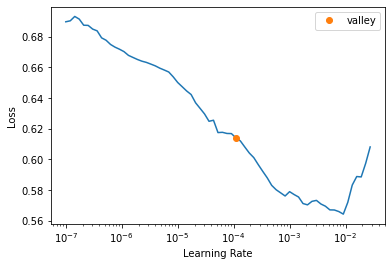

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.420950,0.419018,0.578508,0.236134,01:49
1,0.400514,0.370888,0.578877,0.234389,01:35


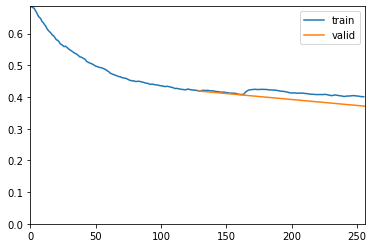

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.361826,0.349114,0.739715,0.443075,01:38
1,0.358993,0.361730,0.773942,0.496715,01:39
2,0.358223,0.330967,0.786462,0.517982,01:36
3,0.353081,0.334256,0.787255,0.519147,01:35
4,0.328459,0.337099,0.780662,0.507822,01:35
5,0.314758,0.318242,0.802286,0.545799,01:36
6,0.316065,0.306590,0.806622,0.553521,01:54
7,0.301401,0.306262,0.808996,0.557842,01:39
8,0.298197,0.301294,0.812532,0.564295,02:19
9,0.284068,0.303243,0.811329,0.561997,01:56


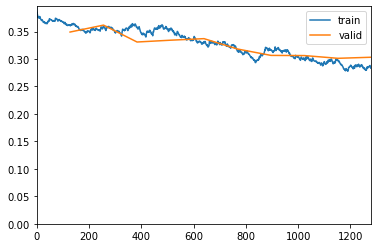

In [8]:
from fastai.callback.progress import ShowGraphCallback
learn.fine_tune(10, freeze_epochs=2, base_lr=3e-4, cbs=ShowGraphCallback)

In [9]:
learn.to_fp32()

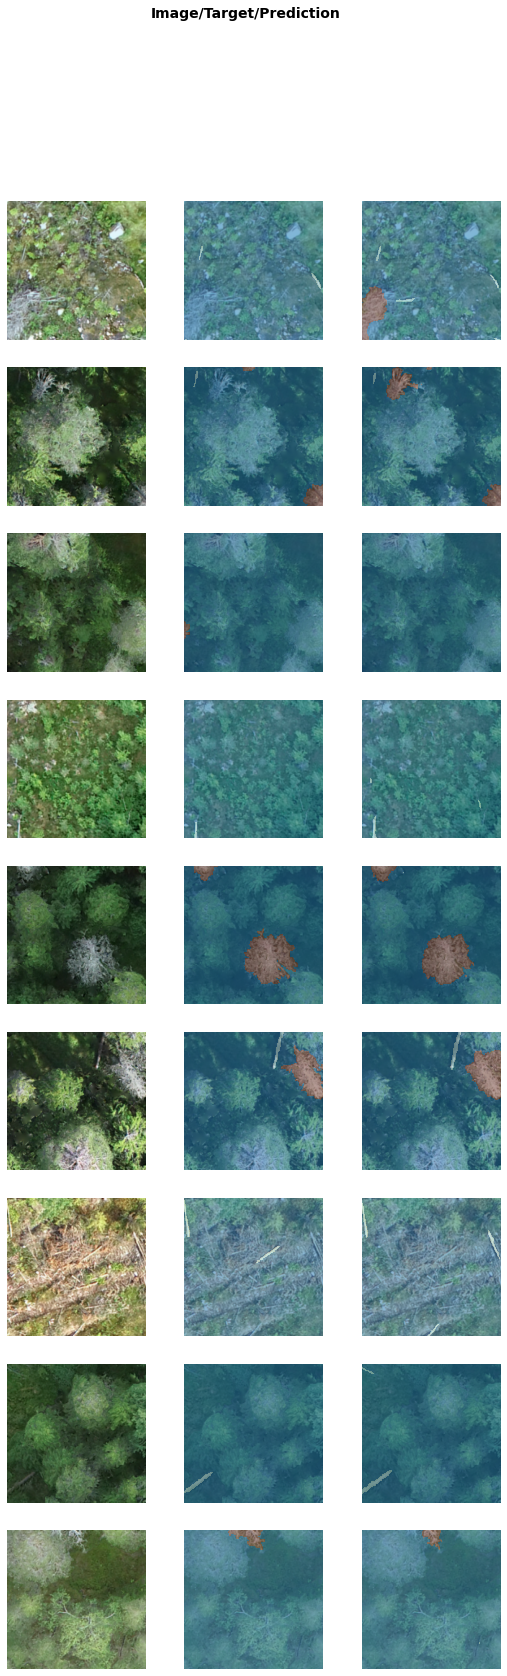

In [11]:
learn.show_results()

In [12]:
learn.path = Path('hiidenportti_models/')

In [13]:
learn.export('unet_hiidenportti_lovasz.pkl')

# Test with holdout

In [14]:
from drone_detector.predict import predict_segmentation

In [15]:
test_rasters = [f'../data/hiidenportti/raw/test_plot_patches/{f}' 
                for f in os.listdir('../data/hiidenportti/raw/test_plot_patches') if f.endswith('tif')]

In [16]:
for t in test_rasters:
    outfile_name = f'../data/hiidenportti/results/unet/{t.split("/")[-1]}'
    predict_segmentation('hiidenportti_models/unet_hiidenportti_lovasz.pkl', t, outfile_name, 
                         processing_dir='temp', use_tta=False,
                         tile_size=256, tile_overlap=128)

Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1053_Hiidenportti_Chunk9_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/10_Hiidenportti_Chunk4_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1035_Hiidenportti_Chunk5_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1025_Hiidenportti_Chunk5_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/109_Hiidenportti_Chunk5_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1047_Hiidenportti_Chunk4_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/11_Hiidenportti_Chunk4_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/114_Hiidenportti_Chunk5_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1038_Hiidenportti_Chunk7_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1033_Hiidenportti_Chunk3_orto.tif to 256x256 tiles with overlap of 128px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files


In [17]:
from osgeo import gdal, ogr

In [18]:
raster_path = '../data/hiidenportti/raw/test_plot_patches/'
vector_path = '../data/hiidenportti/raw/buffered_test_vector_plots/'
rasterized_vector_path = '../data/hiidenportti/results/unet/truths/'
raster_files = sorted([f for f in os.listdir(raster_path)])
vector_files = sorted([f for f in os.listdir(vector_path)])

In [19]:
from tqdm import tqdm
column = 'groundwood'
for r, v in tqdm(zip(raster_files, vector_files)):
    source_raster = gdal.Open(f'{raster_path}/{r}', gdal.GA_ReadOnly)
    source_vector = ogr.Open(f'{vector_path}/{v}')
    source_vector_layer = source_vector.GetLayer()

    output_raster = gdal.GetDriverByName('gtiff').Create(f'{rasterized_vector_path}/{r}',
                                                         source_raster.RasterXSize,
                                                         source_raster.RasterYSize,
                                                         1,
                                                         gdal.GDT_Int16)
    output_raster.SetProjection(source_raster.GetProjectionRef())
    output_raster.SetGeoTransform(source_raster.GetGeoTransform())
    band = output_raster.GetRasterBand(1)
    #band.SetNoDataValue(0)
    gdal.RasterizeLayer(output_raster, [1], source_vector_layer, options=[f'ATTRIBUTE={column}'])

    band = None
    source_vector = None
    source_raster = None
    output_raster = None    

10it [00:02,  3.55it/s]


In [20]:
import rasterio as rio
import rasterio.mask as rio_mask
from shapely.geometry import box

result_path = '../data/hiidenportti/results/unet/preds/'

for f, pred, truth in zip(sorted(os.listdir(vector_path)), sorted(os.listdir(result_path)), sorted(os.listdir(rasterized_vector_path))):
    temp_gdf = gpd.read_file(f'{vector_path}/{f}')
    
    shapes = [box(*temp_gdf.total_bounds)]
    
    with rio.open(f'{result_path}/{pred}') as src:
        out_im, out_tfm = rio_mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_im.shape[1],
                     "width": out_im.shape[2],
                     "transform": out_tfm})
    
    
    with rio.open(f'{result_path}/{pred}', "w", **out_meta) as dest:
        dest.write(out_im)
        
    with rio.open(f'{rasterized_vector_path}/{truth}') as src:
        out_im, out_tfm = rio_mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_im.shape[1],
                     "width": out_im.shape[2],
                     "transform": out_tfm})
    
    
    with rio.open(f'{rasterized_vector_path}/{truth}', "w", **out_meta) as dest:
        dest.write(out_im)

In [21]:
import matplotlib.pyplot as plt
import rasterio.plot as rioplot

<AxesSubplot:>

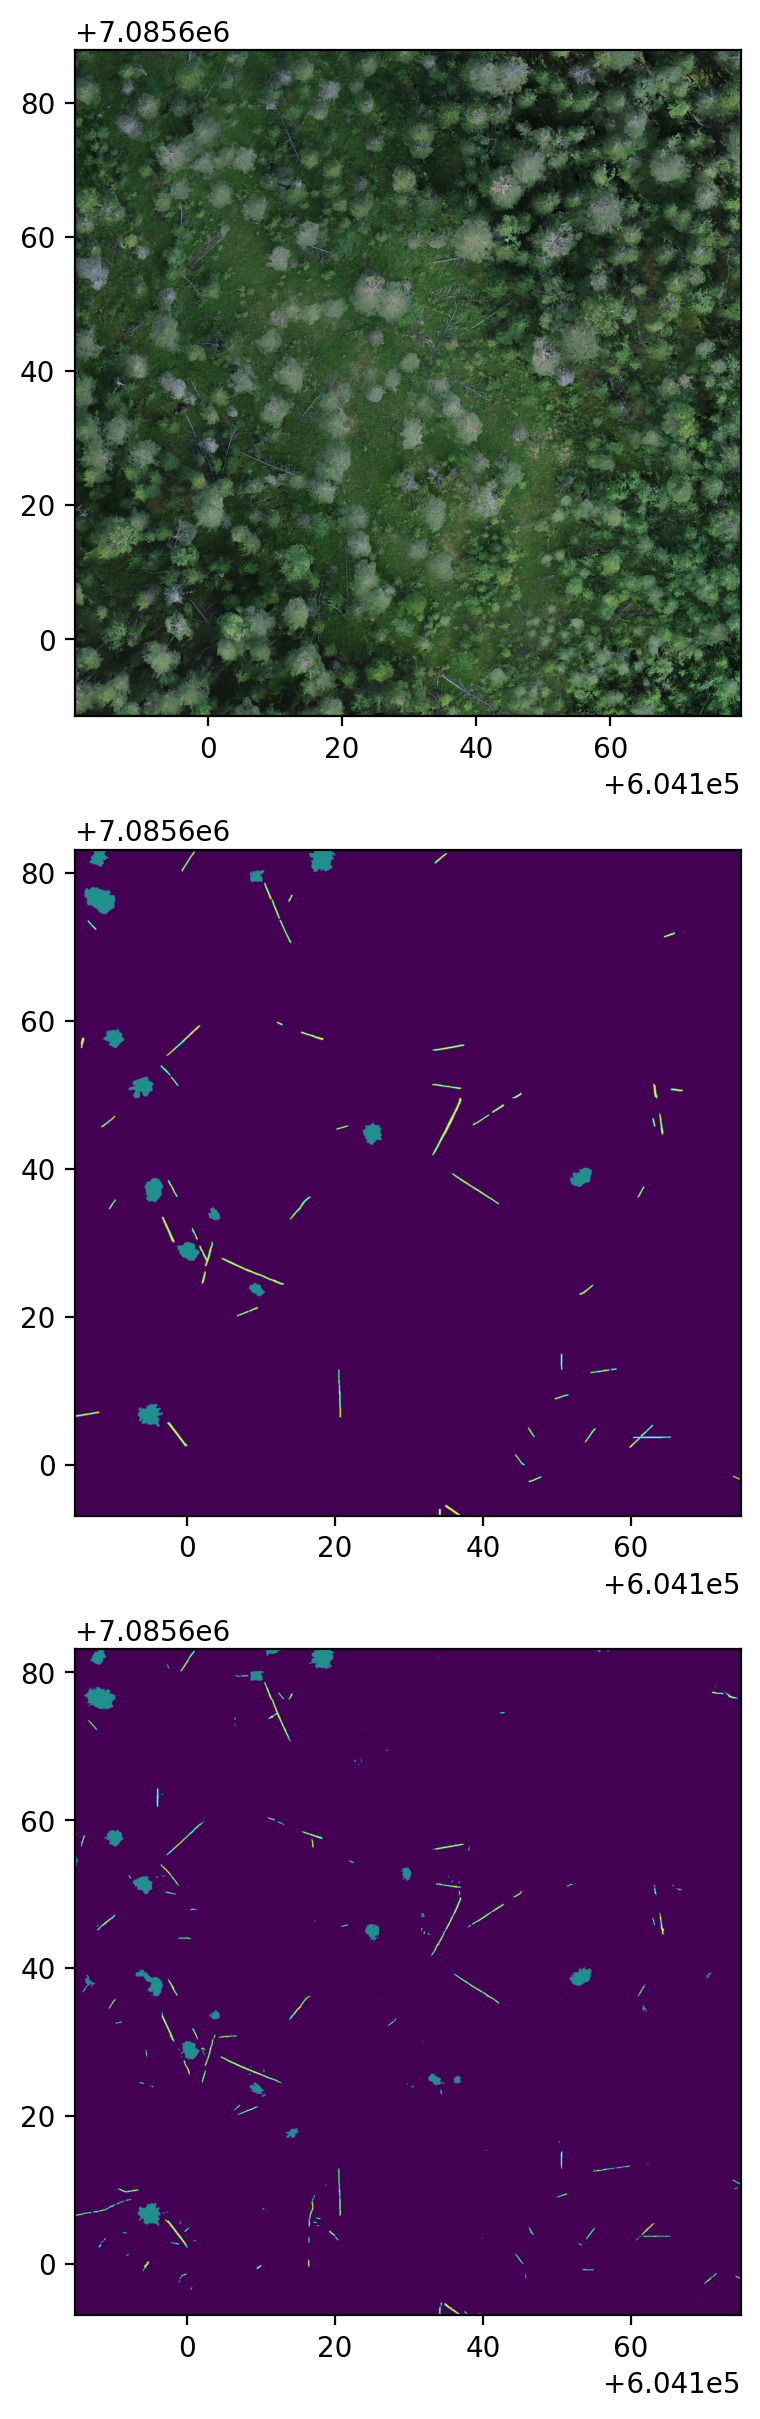

In [80]:
fig, axs = plt.subplots(3,1, figsize=(7,15), dpi=200)

ix = random.randint(0,9)
truths = sorted(os.listdir(rasterized_vector_path))
preds = sorted(os.listdir(result_path))

im = rio.open(f'{raster_path}/{truths[ix]}')
rioplot.show(im, ax=axs[0])

truth = rio.open(f'{rasterized_vector_path}/{truths[ix]}')
rioplot.show(truth, ax=axs[1], vmin=0, vmax=2)

pred = rio.open(f'{result_path}/{truths[ix]}')
rioplot.show(pred, ax=axs[2], vmin=0, vmax=2)

In [81]:
def binary_mask_iou(pred, truth, label=1):
    p = np.where(pred == label, 1, 0)
    t = np.where(truth == label, 1, 0)
    inter = (p*t).sum()
    union = (p+t).sum()
    return inter/(union-inter) if union > 0 else None

In [82]:
standing_iou = binary_mask_iou(truth_vals, pred_vals, 1)
standing_iou

0.5482413195752053

In [83]:
fallen_iou = binary_mask_iou(truth_vals, pred_vals, 2)
fallen_iou

0.5409717560799298

In [84]:
(standing_iou + fallen_iou) / 2

0.5446065378275675